# WEEK 4: PORTFOLIO OPTIMIZATION 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


In [9]:
ret = pd.read_csv("data4_industry_30_vw_monthly.csv", header = 0, index_col = 0, na_values =-99.99)/100
ret.index = pd.to_datetime(ret.index,format ="%Y%m").to_period("M")
ret.columns = ret.columns.str.strip()
ret.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0191,-0.2379,0.0007,0.0187,-0.0002,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0797,...,0.0217,0.0202,0.0439,-0.0238,0.0485,0.0539,-0.0075,-0.0013,0.0447,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0230,...,0.0241,0.0225,0.0019,-0.0554,0.0007,-0.0787,0.0025,-0.0056,-0.0161,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0261,-0.1538,-0.0220,-0.0411,-0.0551,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0310,...,0.0163,0.0377,0.0364,0.0384,0.0161,0.0467,0.0652,0.0433,0.0234,0.0400


In [17]:
n_years = ret["1992":].shape[0]/12
eret = ((1 + ret["1992":]).prod())**(1/n_years)-1
cov = ret["1992":].cov()*12

In [19]:
l = ["Games", "Beer"]
eret[l]
cov.loc[l,l]

,Games,Beer
Games,0.056781,0.012797
Beer,0.012797,0.025237


In [21]:
def portfolio_ret(weights,returns):
    return weights.T@returns

In [63]:
def portfolio_vol(weights,covmat):
    return(weights.T@covmat@weights)**0.5

<Axes: xlabel='volatility'>

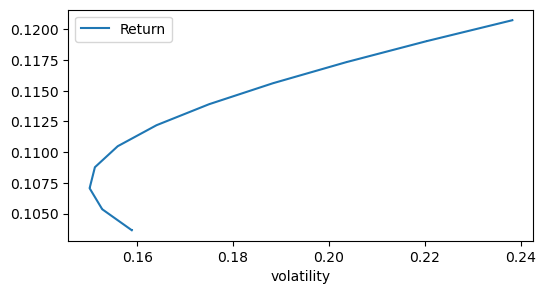

In [77]:
n_points=11
weights =[np.array([w,1-w]) for w in np.linspace(0,1,n_points)]
ereturns = [portfolio_ret(w, eret[l])for w in weights]
vols=[portfolio_vol(w,cov.loc[l,l]) for w in weights]
ef2 = pd.DataFrame({"Return":ereturns,"volatility":vols})
ef2.plot.line(x="volatility",y="Return",figsize =(6,3),style =",-")



#pd.describe

## MULTI  - ASSET EFFICIENT FRONTIER

In [80]:
from scipy.optimize import minimize 


In [106]:
def minimize_vol(target_return, ereturns, covmat):
    n = ereturns.shape[0]
    init_values = np.repeat(1/n, n)
    bounds = [(0, 1) for _ in range(n)]  # Corrected line
    # Constraints:
    weights_sum_to_1 = {'type': 'eq',
                         'fun': lambda weights: np.sum(weights) - 1}

    return_is_target = return_is_target = {'type': 'eq', 'fun': lambda weights: portfolio_ret(weights, ereturns) - target_return}
    results = minimize(portfolio_vol,
                       init_values,
                       args = (covmat,),
                       method ='SLSQP',
                       bounds = bounds,
                       constraints = (weights_sum_to_1, return_is_target),
                       options ={'disp':False })
    weights = results.x
    return weights
       
                       
    
    
    

In [108]:
w11 = minimize_vol(0.11,eret[l],cov.loc[l,l])

w11

array([0.37177817, 0.62822183])

In [110]:
portfolio_ret(w11,eret[l])

0.11000000004810469

In [112]:
portfolio_vol(w11,cov.loc[l,l])

0.15422631467144549

In [122]:
#def optimal_weights(n_points,eretruns,covmat):
    #target_returns = np.linspace(ereturns.min(),ereturns.max(),n_points)
    #opt_weights=[minimize_vol(tr,ereturns,covmat)for tr in target_returns]
    #return opt_weights


def optimal_weights(n_points, ereturns, covmat):
    target_returns = np.linspace(min(ereturns), max(ereturns), n_points)  # Corrected line
    opt_weights = [minimize_vol(tr, ereturns, covmat) for tr in target_returns]
    return opt_weights

<Axes: xlabel='Vol'>

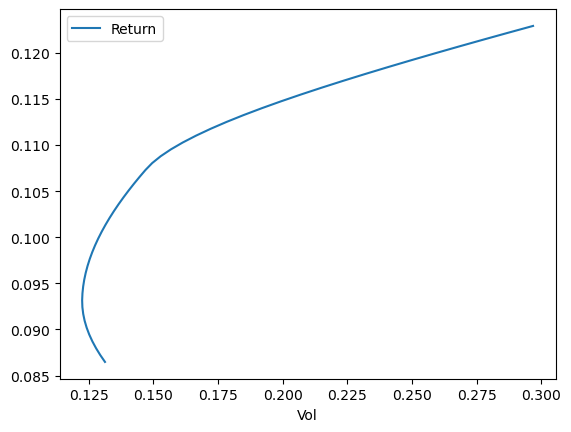

In [130]:
l= ["Food", "Fin", "Hlth", "Autos"]
efweights = optimal_weights(50,eret[l],cov.loc[l,l])
pret = [portfolio_ret(w,eret[l])for w in efweights]
pvol = [portfolio_vol(w,cov.loc[l,l]) for w in efweights]

#ef = pd.DataFrame({"Return": pret, "Vol": pvol})
#ef.plot.line(x="vol",y="Return" , style =",-")

ef = pd.DataFrame({"Return": pret, "Vol": pvol})
ef.plot.line(x="Vol", y="Return", style='-')  # Corrected line